In [1]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# year = '2020'
# years = ['2015','2016','2017','2018','2019','2020']
years = ['2016']
games = {}
for year in years:
    path = os.getcwd()
    path = os.path.abspath(os.path.join(path, os.pardir, 'data/' + year + '_regSeasonPlays.json'))
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2016_regSeasonPlays.json


In [27]:
overtime_faceoffs = []

record = {}
record['game_id'] = ''
record['faceoff_win_player'] = ''
record['faceoff_win_team'] = ''
record['faceoff_lose_player'] = ''
record['faceoff_number'] = 0

for year in games:
    for game_id, game in games[year].items():
        record['game_id'] = game_id
        faceoff_number = 1
        for event in game['events']:
            if event['about']['periodType'] == 'OVERTIME' and event['result']['eventTypeId'] == 'FACEOFF':

                ## which player won/lost this faceoff #
                for player in event['players']:
                    if player['playerType'] == 'Winner':
                        record['faceoff_win_player'] = player['player']['fullName']
                    else:
                        record['faceoff_lose_player'] = player['player']['fullName']

                ## the team of the player who won this faceoff ##
                record['faceoff_win_team'] = event['team']['name']

                ## the number of faceoffs seen in this overtime so far ##
                record['faceoff_number'] = faceoff_number
                faceoff_number += 1

                overtime_faceoffs.append(record.copy())


In [28]:
game_results = []

record = {}
record['game_id'] = ''
record['home_team'] = ''
record['away_team'] = ''
record['home_goals'] = ''
record['away_goals'] = ''
record['winning_team'] = ''
record['losing_team'] = ''
record['last_period'] = ''

for year in games:
    for game_id, game in games[year].items():
        ## game_id and home/away team names ##
        record['game_id'] = game_id
        record['home_team'] = game['home_team']
        record['away_team'] = game['away_team']

        ## get goals for each team ##
        for event in game['events']:
            if event['result']['eventTypeId'] == 'GAME_END':
                record['home_goals'] = event['about']['goals']['home']
                record['away_goals'] = event['about']['goals']['away']
                record['last_period'] = event['about']['periodType']

        ## calculate which team won/lost the game based on number of goals ##
        if record['home_goals'] > record['away_goals']:
            record['winning_team'] = record['home_team']
            record['losing_team'] = record['away_team']
        else:
            record['winning_team'] = record['away_team']
            record['losing_team'] = record['home_team']

        game_results.append(record.copy())


In [29]:
# faceoff data
df_fo = pd.DataFrame.from_dict(overtime_faceoffs)
display(df_fo.head())

# game results data
df_winloss = pd.DataFrame.from_dict(game_results)
display(df_winloss.head())

,game_id,faceoff_win_player,faceoff_win_team,faceoff_lose_player,faceoff_number
0,2016020001,Kyle Turris,Ottawa Senators,Auston Matthews,1
1,2016020007,Evgeny Kuznetsov,Washington Capitals,Evgeni Malkin,1
2,2016020007,Nicklas Backstrom,Washington Capitals,Nick Bonino,2
3,2016020007,Evgeny Kuznetsov,Washington Capitals,Matt Cullen,3
4,2016020007,Nick Bonino,Pittsburgh Penguins,Lars Eller,4


,game_id,home_team,away_team,home_goals,away_goals,winning_team,losing_team,last_period
0,2016020001,Ottawa Senators,Toronto Maple Leafs,5,4,Ottawa Senators,Toronto Maple Leafs,OVERTIME
1,2016020002,Chicago Blackhawks,St. Louis Blues,2,5,St. Louis Blues,Chicago Blackhawks,REGULAR
2,2016020003,Edmonton Oilers,Calgary Flames,7,4,Edmonton Oilers,Calgary Flames,REGULAR
3,2016020004,San Jose Sharks,Los Angeles Kings,2,1,San Jose Sharks,Los Angeles Kings,REGULAR
4,2016020005,Buffalo Sabres,Montréal Canadiens,1,4,Montréal Canadiens,Buffalo Sabres,REGULAR


In [30]:
display(df_winloss['last_period'].value_counts())
display(df_winloss[df_winloss['last_period']=='SHOOTOUT'])

REGULAR     940
OVERTIME    190
SHOOTOUT     99
Name: last_period, dtype: int64

,game_id,home_team,away_team,home_goals,away_goals,winning_team,losing_team,last_period
6,2016020007,Pittsburgh Penguins,Washington Capitals,2,2,Washington Capitals,Pittsburgh Penguins,SHOOTOUT
17,2016020018,Ottawa Senators,Montréal Canadiens,3,3,Montréal Canadiens,Ottawa Senators,SHOOTOUT
28,2016020029,Vancouver Canucks,Calgary Flames,1,1,Calgary Flames,Vancouver Canucks,SHOOTOUT
41,2016020042,Tampa Bay Lightning,Florida Panthers,3,3,Florida Panthers,Tampa Bay Lightning,SHOOTOUT
71,2016020072,Chicago Blackhawks,Toronto Maple Leafs,4,4,Toronto Maple Leafs,Chicago Blackhawks,SHOOTOUT
...,...,...,...,...,...,...,...,...
1176,2016021177,Detroit Red Wings,Ottawa Senators,4,4,Ottawa Senators,Detroit Red Wings,SHOOTOUT
1193,2016021194,Boston Bruins,Ottawa Senators,1,1,Ottawa Senators,Boston Bruins,SHOOTOUT
1213,2016021214,Carolina Hurricanes,St. Louis Blues,4,4,St. Louis Blues,Carolina Hurricanes,SHOOTOUT
1215,2016021216,Dallas Stars,Colorado Avalanche,3,3,Colorado Avalanche,Dallas Stars,SHOOTOUT


In [33]:
df = df_fo.merge(df_winloss[df_winloss['last_period']=='OVERTIME'], how='inner', on='game_id')
df.head()

,game_id,faceoff_win_player,faceoff_win_team,faceoff_lose_player,faceoff_number,home_team,away_team,home_goals,away_goals,winning_team,losing_team,last_period
0,2016020001,Kyle Turris,Ottawa Senators,Auston Matthews,1,Ottawa Senators,Toronto Maple Leafs,5,4,Ottawa Senators,Toronto Maple Leafs,OVERTIME
1,2016020010,Aleksander Barkov,Florida Panthers,Adam Henrique,1,Florida Panthers,New Jersey Devils,2,1,Florida Panthers,New Jersey Devils,OVERTIME
2,2016020010,Pavel Zacha,New Jersey Devils,Vincent Trocheck,2,Florida Panthers,New Jersey Devils,2,1,Florida Panthers,New Jersey Devils,OVERTIME
3,2016020012,Victor Rask,Carolina Hurricanes,Mark Scheifele,1,Winnipeg Jets,Carolina Hurricanes,5,4,Winnipeg Jets,Carolina Hurricanes,OVERTIME
4,2016020012,Mathieu Perreault,Winnipeg Jets,Jeff Skinner,2,Winnipeg Jets,Carolina Hurricanes,5,4,Winnipeg Jets,Carolina Hurricanes,OVERTIME


In [34]:
# interested in how much predictive power the result of the opening faceoff can be, in games the end in overtime
conditions = [df['faceoff_win_team'] == df['winning_team'],]
choices = [1,]

df['faceoffWon_gameWon'] = np.select(conditions, choices, default=0)

In [35]:
df[df['faceoff_number']==1]['faceoffWon_gameWon'].value_counts()

1    101
0     89
Name: faceoffWon_gameWon, dtype: int64

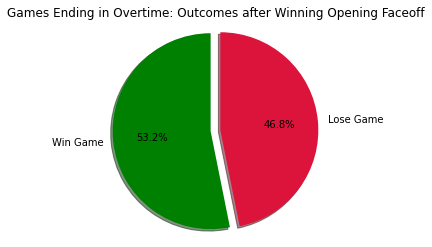

In [36]:
# get counts for game outcomes when the first faceoff of an overtime is won
games_won = df[df['faceoff_number']==1]['faceoffWon_gameWon'].value_counts()[1]
games_lost = df[df['faceoff_number']==1]['faceoffWon_gameWon'].value_counts()[0]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Win Game', 'Lose Game'
sizes = [games_won, games_lost]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=['g', 'crimson'])
ax1.set_title('Games Ending in Overtime: Outcomes after Winning Opening Faceoff')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()